In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape

from alibi_detect.cd import KSDrift
from alibi_detect.cd.preprocess import uae, hidden_output
from alibi_detect.models.resnet import scale_by_instance
from alibi_detect.utils.fetching import fetch_tf_model
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


### Load data

Original CIFAR-10 data:

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)

We evaluate the drift detector on the CIFAR-10-C dataset ([Hendrycks & Dietterich, 2019](https://arxiv.org/abs/1903.12261)). The instances in
CIFAR-10-C have been corrupted and perturbed by various types of noise, blur, brightness etc. at different levels of severity, leading to a gradual decline in the classification model performance.

We can select from the following corruption types at 5 severity levels:

In [4]:
corruptions = corruption_types_cifar10c()
print(corruptions)

['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']


Let's pick a subset of the corruptions at corruption level 5. Each corruption type consists of perturbations on all of the original test set images.

In [5]:
corruption = ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

We split the original test set in a reference dataset and a dataset which should not be rejected under the *H<sub>0</sub>* of the K-S test. We also split the corrupted data by corruption type:

In [6]:
np.random.seed(0)
n_test = X_test.shape[0]
idx = np.random.choice(n_test, size=n_test // 2, replace=False)
idx_h0 = np.delete(np.arange(n_test), idx, axis=0)
X_ref,y_ref = X_test[idx], y_test[idx]
X_h0, y_h0 = X_test[idx_h0], y_test[idx_h0]
print(X_ref.shape, X_h0.shape)

(5000, 32, 32, 3) (5000, 32, 32, 3)


In [7]:
# check that the classes are more or less balanced
classes, counts_ref = np.unique(y_ref, return_counts=True)
counts_h0 = np.unique(y_h0, return_counts=True)[1]
print('Class Ref H0')
for cl, cref, ch0 in zip(classes, counts_ref, counts_h0):
    assert cref + ch0 == n_test // 10
    print('{}     {} {}'.format(cl, cref, ch0))

Class Ref H0
0     472 528
1     510 490
2     498 502
3     492 508
4     501 499
5     495 505
6     493 507
7     501 499
8     516 484
9     522 478


In [8]:
X_c = []
n_corr = len(corruption)
for i in range(n_corr):
    X_c.append(X_corr[i * n_test:(i + 1) * n_test])

We can visualise the same instance for each corruption type:

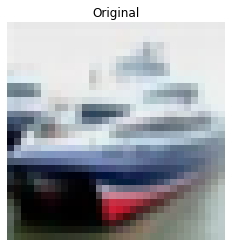

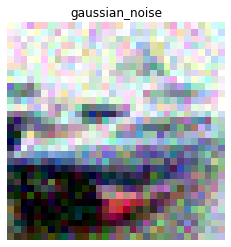

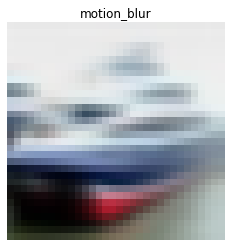

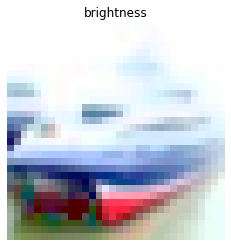

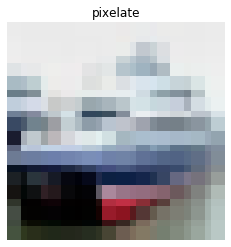

In [9]:
i = 1

n_test = X_test.shape[0]
plt.title('Original')
plt.axis('off')
plt.imshow(X_test[i])
plt.show()
for _ in range(len(corruption)):
    plt.title(corruption[_])
    plt.axis('off')
    plt.imshow(X_corr[n_test * _+ i])
    plt.show()

We can also verify that the performance of a classification model on CIFAR-10 drops significantly on this perturbed dataset:

In [10]:
clf = fetch_tf_model('cifar10', 'resnet32')
acc = clf.evaluate(scale_by_instance(X_test), y_test, batch_size=128, verbose=0)[1]
print('Test set accuracy:')
print('Original {:.4f}'.format(acc))
for _ in range(len(corruption)):
    acc = clf.evaluate(scale_by_instance(X_c[_]), y_test, batch_size=128, verbose=0)[1]
    print('{} {:.4f}'.format(corruption[_], acc))

Test set accuracy:
Original 0.9278
gaussian_noise 0.2208
motion_blur 0.6339
brightness 0.8913
pixelate 0.3666


Given the drop in performance, it is important that we detect the harmful data drift!

### Detect drift

We are trying to detect data drift on high-dimensional (*32x32x3*) data using an aggregation of univariate K-S tests. It therefore makes sense to apply dimensionality reduction first. Some dimensionality reduction methods also used in [Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift](https://arxiv.org/pdf/1810.11953.pdf) are readily available: **UAE** (Untrained AutoEncoder), **BBSDs** (black-box shift detection using the classifier's softmax outputs) and **PCA**. 

#### Untrained AutoEncoder

First we try UAE:

In [11]:
# define encoder
encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)

# initialise drift detector
p_val = .05
cd = KSDrift(
    p_val=p_val,        # p-value for K-S test 
    X_ref=X_ref,       # test against original test set
    preprocess_fn=uae,  # UAE for dimensionality reduction
    preprocess_kwargs={'encoder_net': encoder_net, 'batch_size': 128},
    alternative='two-sided'  # other options: 'less', 'greater'
)

# we can also save/load an initialised detector
filepath = 'my_path'  # change to directory where detector is saved
save_detector(cd, filepath)
cd = load_detector(filepath)

The p-value used by the detector for the multivariate data with *encoding_dim* features is equal to *p_val / encoding_dim* because of the [Bonferroni correction](https://mathworld.wolfram.com/BonferroniCorrection.html).

In [13]:
assert cd.p_val / cd.n_features == p_val / encoding_dim

Let's check whether the detector thinks drift occurred within the original test set:

In [14]:
preds_h0 = cd.predict(X_h0, return_feature_score=True)
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds_h0['data']['is_drift'].item()]))

Drift? No!


As expected, no drift occurred. We can also inspect the p-values for each univariate K-S test by (encoded) feature before the multivariate correction. Most of them are well above the $0.05$ threshold:

In [15]:
print(preds_h0['data']['feature_score'])

[0.45025542 0.5604951  0.677735   0.6945301  0.8367454  0.07549366
 0.32748547 0.10189778 0.01968982 0.2920585  0.62716705 0.5769981
 0.96394527 0.6440195  0.850771   0.8367454  0.88960564 0.7604178
 0.94969434 0.46531922 0.850771   0.45025542 0.5441424  0.80732274
 0.82224816 0.52796143 0.90134364 0.87724036 0.496191   0.420929
 0.9753184  0.80732274]


Let's now check the predictions on the perturbed data:

In [16]:
for x, c in zip(X_c, corruption):
    preds = cd.predict(x, return_feature_score=True)
    print(f'Corruption type: {c}')
    print('Drift? {}'.format(labels[preds['data']['is_drift'].item()]))
    print('Feature-wise p-values:')
    print(preds['data']['feature_score'])
    print('')

Corruption type: gaussian_noise
Drift? Yes!
Feature-wise p-values:
[1.2473309e-05 2.9143179e-03 8.0411826e-07 2.2419506e-09 4.3942747e-03
 1.3455943e-03 5.0361138e-02 9.8394337e-10 2.3615130e-03 4.0832267e-04
 5.1851875e-05 8.5970649e-04 6.2506586e-02 2.9003832e-07 6.0450258e-03
 2.5199042e-04 3.3136364e-02 1.0300793e-03 9.9672265e-03 2.1745481e-04
 2.7166676e-05 1.3189302e-04 6.7440251e-15 6.0763610e-05 3.3770615e-05
 9.4417885e-02 2.5471527e-07 2.1745481e-04 6.5380293e-03 6.2516335e-07
 1.5345249e-04 1.6963646e-04]

Corruption type: motion_blur
Drift? Yes!
Feature-wise p-values:
[2.2357487e-07 3.5845602e-03 8.7565852e-05 4.3264115e-14 1.8742730e-04
 6.2363692e-10 5.9501763e-04 5.0266129e-09 4.2684161e-07 1.0220607e-04
 8.8986745e-03 7.2640061e-10 2.6802295e-03 1.2351299e-07 4.1890446e-05
 7.8477029e-04 1.0220607e-04 9.8394337e-10 7.4963848e-04 3.5646743e-05
 7.1598392e-04 2.4312149e-06 3.0879079e-17 1.6135245e-04 2.3648527e-02
 2.2070335e-02 4.8029385e-08 7.3465863e-03 7.6357084e-03 

#### BBSDs

For **BBSDs**, we use the classifier's softmax outputs for black-box shift detection. This method is based on [Detecting and Correcting for Label Shift with Black Box Predictors](https://arxiv.org/abs/1802.03916). The ResNet classifier is trained on data standardised by instance so we need to rescale the data.

In [17]:
X_train = scale_by_instance(X_train)
X_test = scale_by_instance(X_test)
for i in range(n_corr):
    X_c[i] = scale_by_instance(X_c[i])
X_ref = scale_by_instance(X_ref)
X_h0 = scale_by_instance(X_h0)

Initialisation of the drift detector. Here we use the output of the softmax layer to detect the drift, but other hidden layers can be extracted as well by setting *'layer'* to the index of the desired hidden layer in the model:

In [18]:
p_val = .05
cd = KSDrift(
    p_val=p_val,
    X_ref=X_ref,
    preprocess_fn=hidden_output,
    preprocess_kwargs={'model': clf, 'layer': -1, 'batch_size': 128},  # use output softmax layer
)

Again we can see that the p-value used by the detector for the multivariate data with 10 features (number of CIFAR-10 classes) is equal to *p_val / 10* because of the [Bonferroni correction](https://mathworld.wolfram.com/BonferroniCorrection.html).

In [20]:
assert cd.p_val / cd.n_features == p_val / 10

There is no drift on the original held out test set:

In [21]:
preds_h0 = cd.predict(X_h0, return_feature_score=True)
print('Drift? {}'.format(labels[preds_h0['data']['is_drift'].item()]))
print(preds_h0['data']['feature_score'])

Drift? No!
[0.11774229 0.52796143 0.19387017 0.20236294 0.496191   0.72781175
 0.12345381 0.420929   0.8367454  0.7604178 ]


We compare this with the perturbed data:

In [22]:
for x, c in zip(X_c, corruption):
    preds = cd.predict(x, return_feature_score=True)
    print(f'Corruption type: {c}')
    print('Drift? {}'.format(labels[preds['data']['is_drift'].item()]))
    print('Feature-wise p-values:')
    print(preds['data']['feature_score'])
    print('')

Corruption type: gaussian_noise
Drift? Yes!
Feature-wise p-values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Corruption type: motion_blur
Drift? Yes!
Feature-wise p-values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Corruption type: brightness
Drift? Yes!
Feature-wise p-values:
[0.0000000e+00 4.2024049e-15 2.8963613e-33 4.8499879e-07 2.3718185e-15
 1.2473309e-05 2.9714003e-30 1.0611427e-09 4.6048109e-12 4.1857830e-17]

Corruption type: pixelate
Drift? Yes!
Feature-wise p-values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



### Label drift

We could also use only the original test set data but with class imbalances between the reference data *X_ref* and the tested data *X_h1*. The reference data will use $75$% of the instances of the first 5 classes and only $25$% of the last 5. The data used for drift testing then uses respectively $25$% and $75$% of the test instances for the first and last 5 classes.

In [23]:
np.random.seed(0)
# get index for each class in the test set
num_classes = len(np.unique(y_test))
idx_by_class = [np.where(y_test == c)[0] for c in range(num_classes)]
# sample imbalanced data for different classes for X_ref and X_h1
perc_ref = .75
perc_ref_by_class = [perc_ref if c < 5 else 1 - perc_ref for c in range(num_classes)]
n_by_class = n_test // num_classes
X_ref = []
X_h1 = []
for _ in range(num_classes):
    idx_class_ref = np.random.choice(n_by_class, size=int(perc_ref_by_class[_] * n_by_class), replace=False)
    idx_ref = idx_by_class[_][idx_class_ref]
    idx_class_h1 = np.delete(np.arange(n_by_class), idx_class_ref, axis=0)
    idx_h1 = idx_by_class[_][idx_class_h1]
    assert idx_ref != idx_h1
    X_ref.append(X_test[idx_ref])
    X_h1.append(X_test[idx_h1])
X_ref = np.concatenate(X_ref)
X_h1 = np.concatenate(X_h1)
print(X_ref.shape, X_h1.shape)

(5000, 32, 32, 3) (5000, 32, 32, 3)


/home/avl/anaconda3/envs/detect/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  app.launch_new_instance()


Update reference dataset for the detector and make predictions:

In [24]:
cd.X_ref = X_ref

In [25]:
preds_h1 = cd.predict(X_h1, return_feature_score=True)
print('Drift? {}'.format(labels[preds_h1['data']['is_drift'].item()]))
print(preds_h1['data']['feature_score'])

Drift? Yes!
[6.10830360e-20 1.32319470e-20 7.62410424e-29 1.05537245e-17
 7.68910424e-23 1.57479264e-15 5.77457112e-19 1.94419707e-20
 5.02102509e-21 4.13147353e-21]


### Update reference data

So far we have kept the reference data the same throughout the experiments. It is possible however that we want to test a new batch against the last *N* instances or against a batch of instances of fixed size where we give each instance we have seen up until now the same chance of being in the reference batch (*reservoir sampling*). The `update_X_ref` argument allows you to change the reference data update rule. It is a Dict which takes as key the update rule (*'last'* for last *N* instances or *'reservoir_sampling'*) and as value the batch size *N* of the reference data. You can also save the detector after the prediction calls to save the updated reference data.

In [26]:
N = 7500
cd = KSDrift(
    p_val=.05,
    X_ref=X_ref,
    update_X_ref={'reservoir_sampling': N},
    preprocess_fn=hidden_output,
    preprocess_kwargs={'model': clf, 'layer': -1, 'batch_size': 128},
)

The reference data is now updated with each `predict` call. Say we start with our imbalanced reference set and make a prediction on the remaining test set data *X_h1*, then the drift detector will figure out data drift has occurred.

In [27]:
preds_h1 = cd.predict(X_h1)
print('Drift? {}'.format(labels[preds_h1['data']['is_drift'].item()]))

Drift? Yes!


We can now see that the reference data consists of *N* instances, obtained through reservoir sampling.

In [28]:
assert cd.X_ref.shape[0] == N

We then draw a random sample from the training set and compare it with the updated reference data. This still highlights that there is data drift but will update the reference data again:

In [29]:
np.random.seed(0)
perc_train = .5
n_train = X_train.shape[0]
idx_train = np.random.choice(n_train, size=int(perc_train * n_train), replace=False)

In [30]:
preds_train = cd.predict(X_train[idx_train])
print('Drift? {}'.format(labels[preds_train['data']['is_drift'].item()]))

Drift? Yes!


When we draw a new sample from the training set, it highlights that it is not drifting anymore against the reservoir in *X_ref*.

In [31]:
perc_train = .1
idx_train = np.random.choice(n_train, size=int(perc_train * n_train), replace=False)
preds_train = cd.predict(X_train[idx_train])
print('Drift? {}'.format(labels[preds_train['data']['is_drift'].item()]))

Drift? No!


### Multivariate correction mechanism

Instead of the Bonferroni correction for multivariate data, we can also use the less conservative [False Discovery Rate](http://www.math.tau.ac.il/~ybenja/MyPapers/benjamini_hochberg1995.pdf) (FDR) correction. See [here](https://riffyn.com/riffyn-blog/2017/10/29/false-discovery-rate) or [here](https://matthew-brett.github.io/teaching/fdr.html) for nice explanations. While the Bonferroni correction controls the probability of at least one false positive, the FDR correction controls for an expected amount of false positives. The `p_val` argument at initialisation time can be interpreted as the acceptable q-value when the FDR correction is applied.

In [32]:
cd = KSDrift(
    p_val=.05,
    correction='fdr',
    X_ref=X_ref,
    preprocess_fn=hidden_output,
    preprocess_kwargs={'model': clf, 'layer': -1, 'batch_size': 128},  # use output softmax layer
)

preds_h1 = cd.predict(X_h1)
print('Drift? {}'.format(labels[preds_h1['data']['is_drift'].item()]))

Drift? Yes!


### Train vs. test set drift

Let us do a last check and see whether there is data drift between the original train and test sets. We will use both the **BBSDs** and **Untrained AutoEncoder** preprocessing techniques. We start with BBSDs:

In [33]:
cd = KSDrift(
    p_val=.05,
    X_ref=X_train,
    preprocess_fn=hidden_output,
    preprocess_kwargs={'model': clf, 'layer': -1, 'batch_size': 128},
)

preds_test = cd.predict(X_test)
print('Drift? {}'.format(labels[preds_test['data']['is_drift'].item()]))

Drift? Yes!


So when we use the softmax output of the classification model, we pick up drift. It is important to notice that this is drift with respect to the classifier output. This means that the detector picked up a difference between the distributions of the softmax probabilities of the model on the train and test sets.

When we use the UAE to preprocess the data we do not care about the distribution of the labels being predicted and only take random projections of the input on the latent dimension into account.

In [36]:
cd = KSDrift(
    p_val=.05,
    X_ref=X_train,
    preprocess_fn=uae,
    preprocess_kwargs={'encoder_net': encoder_net, 'batch_size': 128},
)

preds_test = cd.predict(X_test)
print('Drift? {}'.format(labels[preds_test['data']['is_drift'].item()]))

Drift? No!


The UAE detector does not pick up drift. This means that the input data of the classification model does not seem to drift between the train and test set, but the model output does!